In [159]:
from urllib.parse import urlencode
from urllib.request import urlopen
import pickle
import json
from collections import OrderedDict
import numpy as np
import os


class SubmissionBase:

    submit_url = 'https://www-origin.coursera.org/api/' \
                 'onDemandProgrammingImmediateFormSubmissions.v1'
    save_file = 'token.pkl'

    def __init__(self, assignment_slug, part_names):
        self.assignment_slug = assignment_slug
        self.part_names = part_names
        self.login = None
        self.token = None
        self.functions = OrderedDict()
        self.args = dict()

    def grade(self):
        print('\nSubmitting Solutions | Programming Exercise %s\n' % self.assignment_slug)
        self.login_prompt()

        # Evaluate the different parts of exercise
        parts = OrderedDict()
        for part_id, result in self:
            parts[str(part_id)] = {'output': sprintf('%0.5f ', result)}
        result, response = self.request(parts)
        response = json.loads(response.decode("utf-8"))

        # if an error was returned, print it and stop
        if 'errorMessage' in response:
            print(response['errorMessage'])
            return

        # Print the grading table
        print('%43s | %9s | %-s' % ('Part Name', 'Score', 'Feedback'))
        print('%43s | %9s | %-s' % ('---------', '-----', '--------'))
        for part in parts:
            part_feedback = response['partFeedbacks'][part]
            part_evaluation = response['partEvaluations'][part]
            score = '%d / %3d' % (part_evaluation['score'], part_evaluation['maxScore'])
            print('%43s | %9s | %-s' % (self.part_names[int(part) - 1], score, part_feedback))
        evaluation = response['evaluation']
        total_score = '%d / %d' % (evaluation['score'], evaluation['maxScore'])
        print('                                  --------------------------------')
        print('%43s | %9s | %-s\n' % (' ', total_score, ' '))

    def login_prompt(self):
        if os.path.isfile(self.save_file):
            with open(self.save_file, 'rb') as f:
                login, token = pickle.load(f)
            reenter = input('Use token from last successful submission (%s)? (Y/n): ' % login)

            if reenter == '' or reenter[0] == 'Y' or reenter[0] == 'y':
                self.login, self.token = login, token
                return
            else:
                os.remove(self.save_file)

        self.login = input('Login (email address): ')
        self.token = input('Token: ')

        # Save the entered credentials
        if not os.path.isfile(self.save_file):
            with open(self.save_file, 'wb') as f:
                pickle.dump((self.login, self.token), f)

    def request(self, parts):
        params = {
            'assignmentSlug': self.assignment_slug,
            'secret': self.token,
            'parts': parts,
            'submitterEmail': self.login}

        params = urlencode({'jsonBody': json.dumps(params)}).encode("utf-8")
        f = urlopen(self.submit_url, params)
        try:
            return 0, f.read()
        finally:
            f.close()

    def __iter__(self):
        for part_id in self.functions:
            yield part_id

    def __setitem__(self, key, value):
        self.functions[key] = value


def sprintf(fmt, arg):
    """ Emulates (part of) Octave sprintf function. """
    if isinstance(arg, tuple):
        # for multiple return values, only use the first one
        arg = arg[0]

    if isinstance(arg, (np.ndarray, list)):
        # concatenates all elements, column by column
        return ' '.join(fmt % e for e in np.asarray(arg).ravel('F'))
    else:
        return fmt % arg

In [160]:
import sys
import numpy as np
from matplotlib import pyplot

sys.path.append('..')



def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p


def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.
    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.
    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.
    fan_in : int
        The number of incoming connections.
    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W


def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.
    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.
    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)


def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))


class Grader(SubmissionBase):
    X = np.reshape(3 * np.sin(np.arange(1, 31)), (3, 10), order='F')
    Xm = np.reshape(np.sin(np.arange(1, 33)), (16, 2), order='F') / 5
    ym = np.arange(1, 17) % 4
    t1 = np.sin(np.reshape(np.arange(1, 25, 2), (4, 3), order='F'))
    t2 = np.cos(np.reshape(np.arange(1, 41, 2), (4, 5), order='F'))
    t = np.concatenate([t1.ravel(), t2.ravel()], axis=0)

    def __init__(self):
        part_names = ['Feedforward and Cost Function',
                      'Regularized Cost Function',
                      'Sigmoid Gradient',
                      'Neural Network Gradient (Backpropagation)',
                      'Regularized Gradient']
        super().__init__('neural-network-learning', part_names)

    def __iter__(self):
        for part_id in range(1, 6):
            try:
                func = self.functions[part_id]

                # Each part has different expected arguments/different function
                if part_id == 1:
                    res = func(self.t, 2, 4, 4, self.Xm, self.ym, 0)[0]
                elif part_id == 2:
                    res = func(self.t, 2, 4, 4, self.Xm, self.ym, 1.5)
                elif part_id == 3:
                    res = func(self.X, )
                elif part_id == 4:
                    J, grad = func(self.t, 2, 4, 4, self.Xm, self.ym, 0)
                    grad1 = np.reshape(grad[:12], (4, 3))
                    grad2 = np.reshape(grad[12:], (4, 5))
                    grad = np.concatenate([grad1.ravel('F'), grad2.ravel('F')])
                    res = np.hstack([J, grad]).tolist()
                elif part_id == 5:
                    J, grad = func(self.t, 2, 4, 4, self.Xm, self.ym, 1.5)
                    grad1 = np.reshape(grad[:12], (4, 3))
                    grad2 = np.reshape(grad[12:], (4, 5))
                    grad = np.concatenate([grad1.ravel('F'), grad2.ravel('F')])
                    res = np.hstack([J, grad]).tolist()
                else:
                    raise KeyError
                yield part_id, res
            except KeyError:
                yield part_id, 0

In [161]:

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

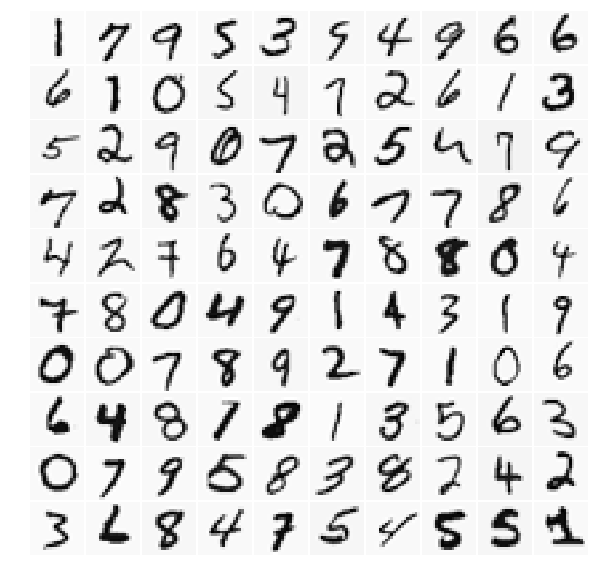

In [162]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [163]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])




def sigmoid(X):
    answer = 1/(1+np.exp(-X))
    return answer

In [164]:
def sigmoidGradient(z):

    
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    
    Instructions
    ------------
    Compute the gradient of the sigmoid function evaluated at
    each value of z (z can be a matrix, vector or scalar).
    
    Note
    ----
    We have provided an implementation of the sigmoid function 
    in `utils.py` file accompanying this assignment.
    """

    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================

    g = (1/(1+np.exp(-z)))
    g *= 1-(1/(1+np.exp(-z)))

    # =============================================================
    return g

In [165]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


In [166]:

# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


In [167]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    Instructions
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ====================== YOUR CODE HERE ======================

    # Randomly initialize the weights to small values
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    # ============================================================
    return W

In [168]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


In [185]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================
    

    trainingEx = X.shape[0]
    ones= np.ones((trainingEx, 1))
    
    ###a1 == X
    X = np.concatenate((ones,X),axis = 1)
    
    
    
    #a2 corresponds to our middle layers.
    #a2 = sigmoid(theta1 -dotProduct- X)
    a2 = sigmoid(X.dot(Theta1.T))
    
    #Our only hidden layer, a2, will have a column of ones to calculate bias terms
    a2 = np.concatenate((ones,a2),axis = 1)
    
    
    h = sigmoid(a2.dot(Theta2.T))
    
    #Save these variables for back prop later.
    #These are the activations for each layer, meaning they have been 
    #processed by the sigmoid function, excluding a1 since that is our input layer
    #with a bias term:
    a1 = X
    a2 = a2
    a3 = h
    z2 = a1.dot(Theta1.T)
    z2 = np.concatenate((ones,z2),axis = 1)

    z3 = a2.dot(Theta2.T)

    newY = np.zeros((y.size,num_labels))
   
    #We must turn array y into an array that stores 1d vectors of the classifications
    for i in range(y.size):
        newY[i,y[i]] = 1
    y = newY

    """""
     Lets think of the cost function for a NN:
     In our first cost function, all we really do is take our 1d array of
     training examples in y and take the 1d array of hypothesis (final layer output)
     and plug it into the logistic regression cost function.
     Very straightforward.
     
     It gets complex when having multiple classes.
     
     We have:
     
     h = 5000 x 10 matrix containing the values for each node of the 10 possible 
     classification nodes
     
     y = 5000 x 10 matrix containing the classification ANSWERS for 
     all training examples.
     
     think of it in sum of squares
     
   summation(i,5000) [ (h1i - y1i)^2 + (h2i-y2i)^2 + (h3i-y3i)^2 ]
   
   assume there are k = 3 classes for now
   --> expanded as 
 
    (h1,1 - y1,1)^2 + (h2,1-y2,1)^2 + (h3,1-y3,1)^2 
    +
    (h1,2 - y1,2)^2 + (h2,2-y2,2)^2 + (h3,2-y3,2)^2
    +
    ...
    (h1,5000 - y1,5000)^2 + (h2,5000-y2,5000)^2 + (h3,5000-y3,5000)^2
      
     What does this all mean?
     for every single class, we take the sum of squares of each 
     
     lets express y as an output layer with the # of nodes in y == # of nodes in h
     
     (this makes intuitive sense as each training example in y is a K sized vector 
      and there is a 1 in the index 0 <= k <= K representing the ith classification)
      
      
      for every single node, we take the difference between classifications and sqaure them.
      After that, we add them up for the ith example.
      
      Repeat this operation for all m training examples.
      
      Thats it.
      
      All we do is take our final layer's output result, take our y's result
      where y will contain as many K-sized vetors, perform elementwise operation for
      each k out node, (sum of squares, logistic regression cost formula, etc.), 
      take that sum for this ith example,
      
      store all the sums for each ith example example as 
      a 5000 x 1 array 
      
      and take that sum divided by -m
      
      thats the answer.
   
     
    """""

    J = np.multiply(y,np.log(h)) + np.multiply(1-y,np.log(1-h))
    J = np.sum(np.sum(J,axis = 1))
    J = J/-m
    
    
    tempTheta1 = Theta1
    tempTheta2 = Theta2
    
    Theta1 = np.delete(Theta1,0,1)
    Theta2 = np.delete(Theta2,0,1)
    sumThetasReg = np.sum(Theta2 * Theta2)
    sumThetasReg = sumThetasReg + np.sum(Theta1 *Theta1)
    Regularization = (lambda_/(2*m)) *(sumThetasReg)
   
    
    J += Regularization
   
    Theta1 = tempTheta1
    Theta2 = tempTheta2
    
    #Good thing: You named all variables a1, a2, z2, etc. right
    #You had the a3 - y correct
    #Back Propogration Section:    

    """
    The important variables
    
    a1 = X
    a2 = a2
    a3 = h
    z2 = a1.dot(Theta1.T)
    z2 = np.concatenate((ones,z2),axis = 1)

    z3 = a2.dot(Theta2.T)

    """
    
    #delta_3.dot(Theta2)[:,1:]  prints out all the rows and prints out all
    #columns starting at index 1
    
    # Add regularization to gradient]
   
    delta3 = (a3 - y)
    delta2 = np.multiply(delta3.dot(Theta2)[:,1:],sigmoidGradient(z2)[:,1:])
    

    #Based on the formula. We do this for all elements in the array
    Delta1 = delta2.T.dot(a1)
    Delta2 = delta3.T.dot(sigmoidGradient(X.dot(Theta1.T)))

    #Regularization
    Theta1_grad = Delta1/m
    Theta2_grad = Delta1/m
    
    Theta1_grad[:,1:] =  Theta1_grad[:, 1:] + (lambda_/m) * (Theta1[:,1:])
    Theta2_grad[:,1:] =  Theta2_grad[:, 1:] + (lambda_/m) * (Theta1[:,1:])
    
    
    # ================================================================
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    

    return J, grad

In [186]:

# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

IndexError: arrays used as indices must be of integer (or boolean) type

In [183]:

#  Check gradients by running checkNNGradients
lambda_ = 3


# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')



Cost at (fixed) debugging parameters (w/ lambda = 3.000000): 0.576051 
(for lambda = 3, this value should be about 0.576051)


In [187]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

IndexError: arrays used as indices must be of integer (or boolean) type

In [188]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 97.520000


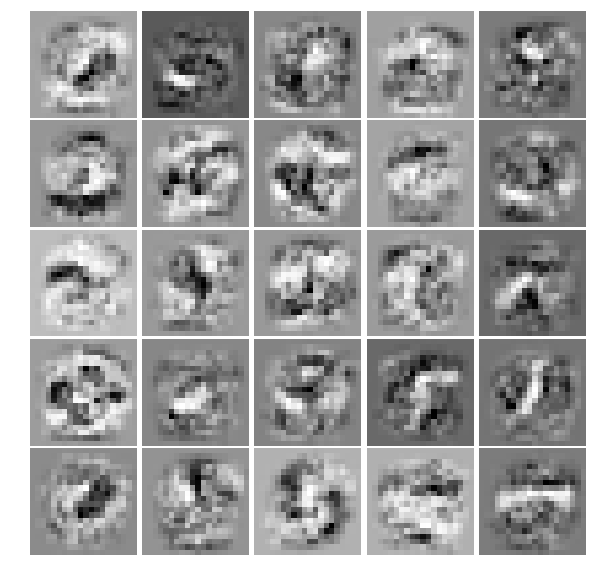

In [189]:
displayData(Theta1[:, 1:])